In [1]:
# import deeplc packages
from deeplc import DeepLC
from deeplcretrainer import deeplcretrainer

# Default
from collections import Counter
import os
import urllib.request

# specific packages
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import numpy as np

import tensorflow as tf
from tensorflow.python.eager import context

import warnings
warnings.filterwarnings('ignore')
os.chdir('/cmnfs/home/z.xiao/miniconda3/envs/dlomix/lib')
os.getcwd()

seed = 42
tf.random.set_seed(seed)

In [2]:
# load data and split
df = pd.read_csv('/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/notebooks/evidence_RT_transfer.csv', 
                          index_col=0)
df_train = df.sample(frac=0.9, random_state=seed)
df_test = df.loc[df.index.difference(df_train.index)]

df_train.fillna("",inplace=True)
df_test.fillna("",inplace=True)


In [3]:
# obtain three models from mods dir in github
# MAKE SURE TO USE THESE MODELS!!!
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/compomics/DeepLC/master/deeplc/mods/full_hc_PXD005573_mcp_1fd8363d9af9dcad3be7553c39396960.hdf5",
    "full_hc_train_pxd001468_1fd8363d9af9dcad3be7553c39396960.hdf5"
)
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/compomics/DeepLC/master/deeplc/mods/full_hc_PXD005573_mcp_8c22d89667368f2f02ad996469ba157e.hdf5",
    "full_hc_train_pxd001468_8c22d89667368f2f02ad996469ba157e.hdf5"
)

urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/compomics/DeepLC/master/deeplc/mods/full_hc_PXD005573_mcp_cb975cfdd4105f97efa0b3afffe075cc.hdf5",
    "full_hc_train_pxd001468_cb975cfdd4105f97efa0b3afffe075cc.hdf5"
)


('full_hc_train_pxd001468_cb975cfdd4105f97efa0b3afffe075cc.hdf5',
 <http.client.HTTPMessage at 0x7ff8d4165f10>)

# Calibration

In [4]:
%%capture

# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# Make sure we have no NA in the dataframes
df_test['modifications'] = df_test['modifications'].fillna("")
df_train['modifications'] = df_train['modifications'].fillna("")

# Call DeepLC with the downloaded models, say that we use GAM calibration
dlc = DeepLC(
        path_model=["full_hc_train_pxd001468_1fd8363d9af9dcad3be7553c39396960.hdf5",
                    "full_hc_train_pxd001468_8c22d89667368f2f02ad996469ba157e.hdf5",
                    "full_hc_train_pxd001468_cb975cfdd4105f97efa0b3afffe075cc.hdf5",],
        batch_num=1024000,
        pygam_calibration=True
)

# Perform calibration, make predictions and calculate metrics
dlc.calibrate_preds(seq_df=df_train)


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 264ms/step


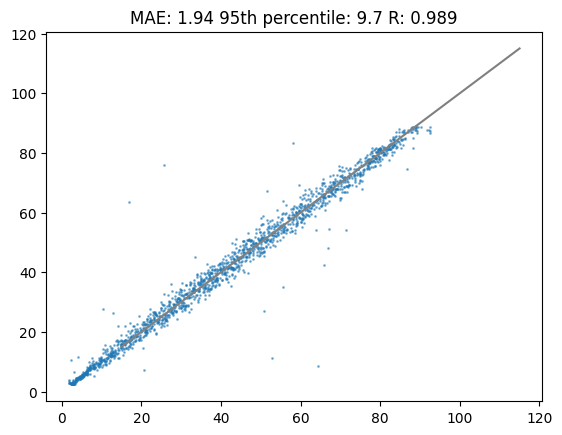

In [5]:
preds_calib = dlc.make_preds(seq_df=df_test)

mae_calib = sum(abs(df_test["tr"]-preds_calib))/len(df_test["tr"].index)
perc95_calib = np.percentile(abs(df_test["tr"]-preds_calib),95)*2
cor_calib = pearsonr(df_test["tr"],preds_calib)[0]

%matplotlib inline

plt.title(f"MAE: {round(mae_calib,2)} 95th percentile: {round(perc95_calib,2)} R: {round(cor_calib,3)}")
plt.scatter(df_test["tr"],preds_calib,s=1,alpha=0.5)
plt.plot([15,115],[15,115],c="grey")
plt.show()

15/15 [==============================] - 0s 11ms/step


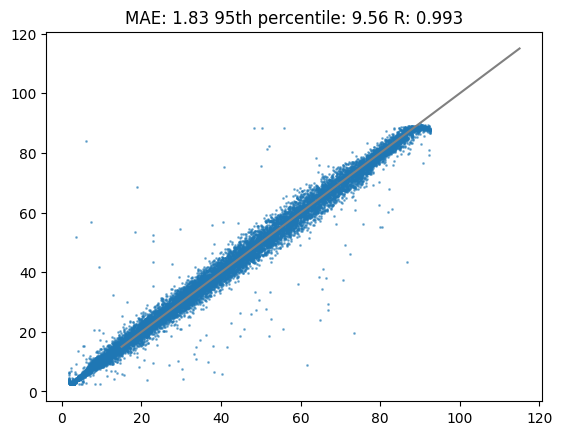

In [6]:
preds_calib_train = dlc.make_preds(seq_df=df_train)
mae_calib_train = sum(abs(df_train["tr"]-preds_calib_train))/len(df_train["tr"].index)
perc95_calib_train = np.percentile(abs(df_train["tr"]-preds_calib_train),95)*2
cor_calib_train = pearsonr(df_train["tr"],preds_calib_train)[0]

%matplotlib inline

plt.title(f"MAE: {round(mae_calib_train,2)} 95th percentile: {round(perc95_calib_train,2)} R: {round(cor_calib_train,3)}")
plt.scatter(df_train["tr"],preds_calib_train,s=1,alpha=0.5)
plt.plot([15,115],[15,115],c="grey")
plt.show()

# Transfer Learning

In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('always')
# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# For training new models we need to use a file, so write the train df to a file
df_train.to_csv("train.csv",index=False)
df_train_file = "train.csv"

# Here we will apply transfer learning we specify previously trained models in the 'mods_transfer_learning'
models = deeplcretrainer.retrain(
    [df_train_file],
    mods_transfer_learning=[
        "full_hc_train_pxd001468_1fd8363d9af9dcad3be7553c39396960.hdf5",
        "full_hc_train_pxd001468_8c22d89667368f2f02ad996469ba157e.hdf5",
        "full_hc_train_pxd001468_cb975cfdd4105f97efa0b3afffe075cc.hdf5"
    ],
    freeze_layers=True,
    n_epochs=10,
    freeze_after_concat=1
);

# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# Make a DeepLC object with the models trained previously
dlc = DeepLC(
        path_model=models,
        batch_num=1024000,
        pygam_calibration=False
)

# Perform calibration, make predictions and calculate metrics
dlc.calibrate_preds(seq_df=df_train)


Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7ff8feda5e40>
Traceback (most recent call last):
  File "/cmnfs/home/z.xiao/miniconda3/envs/dlomix/lib/python3.11/site-packages/tensorflow/python/eager/polymorphic_function/monomorphic_function.py", line 172, in __del__
    context.remove_function(self.name)
  File "/cmnfs/home/z.xiao/miniconda3/envs/dlomix/lib/python3.11/site-packages/tensorflow/python/eager/context.py", line 2724, in remove_function
    context().remove_function(name)
  File "/cmnfs/home/z.xiao/miniconda3/envs/dlomix/lib/python3.11/site-packages/tensorflow/python/eager/context.py", line 1387, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function '__inference_predict_function_27698'.
DeepLC tried to set intra op threads, but was unable to do so.


Epoch 1/10
100/100 [==============================] - 4s 11ms/step - loss: 10.9677 - mean_absolute_error: 10.9529 - val_loss: 1.7573 - val_mean_absolute_error: 1.7425
Epoch 2/10
100/100 [==============================] - 0s 4ms/step - loss: 1.4653 - mean_absolute_error: 1.4505 - val_loss: 1.5357 - val_mean_absolute_error: 1.5209
Epoch 3/10
100/100 [==============================] - 0s 4ms/step - loss: 1.3623 - mean_absolute_error: 1.3475 - val_loss: 1.5437 - val_mean_absolute_error: 1.5290
Epoch 4/10
100/100 [==============================] - 0s 4ms/step - loss: 1.2902 - mean_absolute_error: 1.2754 - val_loss: 1.3222 - val_mean_absolute_error: 1.3074
Epoch 5/10
100/100 [==============================] - 0s 4ms/step - loss: 1.2527 - mean_absolute_error: 1.2379 - val_loss: 1.2846 - val_mean_absolute_error: 1.2698
Epoch 6/10
100/100 [==============================] - 0s 4ms/step - loss: 1.2408 - mean_absolute_error: 1.2260 - val_loss: 1.2708 - val_mean_absolute_error: 1.2560
Epoch 7/10
10

Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7ff8feda5e40>
Traceback (most recent call last):
  File "/cmnfs/home/z.xiao/miniconda3/envs/dlomix/lib/python3.11/site-packages/tensorflow/python/eager/polymorphic_function/monomorphic_function.py", line 172, in __del__
    context.remove_function(self.name)
  File "/cmnfs/home/z.xiao/miniconda3/envs/dlomix/lib/python3.11/site-packages/tensorflow/python/eager/context.py", line 2724, in remove_function
    context().remove_function(name)
  File "/cmnfs/home/z.xiao/miniconda3/envs/dlomix/lib/python3.11/site-packages/tensorflow/python/eager/context.py", line 1387, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function '__inference_Dataset_map_grab_batch_29626'.
Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7ff8feda5e40>
Traceback (most recent call last):
  File "/cm

15/15 [==============================] - 0s 11ms/step


{}

2/2 [==============================] - 0s 10ms/step


2/2 [==============================] - 0s 11ms/step


Text(0.5, 1.0, 'MAE: 1.32 95th percentile: 6.19 R: 0.991')

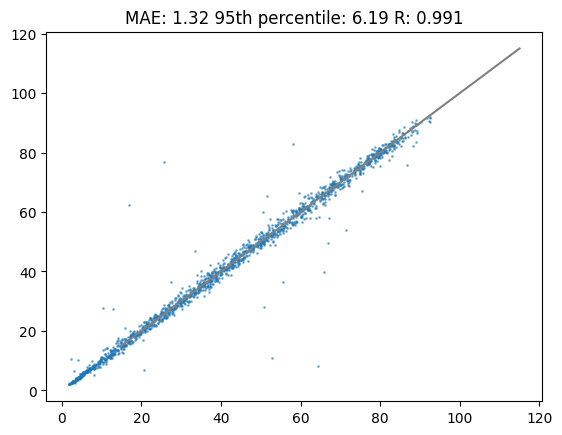

In [8]:
preds_transflearn = dlc.make_preds(seq_df=df_test)

mae_transflearn = sum(abs(df_test["tr"]-preds_transflearn))/len(df_test["tr"].index)
perc95_transflearn = np.percentile(abs(df_test["tr"]-preds_transflearn),95)*2
cor_transflearn = pearsonr(df_test["tr"],preds_transflearn)[0]

%matplotlib inline

plt.title(f"MAE: {round(mae_transflearn,2)} 95th percentile: {round(perc95_transflearn,2)} R: {round(cor_transflearn,3)}")
plt.scatter(df_test["tr"],preds_transflearn,s=1,alpha=0.5)
plt.plot([15,115],[15,115],c="grey")
plt.show()

In [9]:
# eval
%matplotlib inline
import utils.metrics
reload(utils.metrics)
from utils.metrics import RT_metrics
RTmetric = RT_metrics(RT_obs = df_test["tr"], RT_pred = df_test[trans_pred_col])
print('MAE: ', RTmetric.CalcMAE())
print('Delta RT 95%: ', RTmetric.CalcDeltaRTwidth(95))
print('Pearson Corr: ', RTmetric.CalcPrsCorr())
RTmetric.PlotRTScatter()

ModuleNotFoundError: No module named 'utils'